In [ ]:
# import tensorflow as tf
# tf.config.list_physical_devices()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# Training Set

In [107]:
# Normalizing data for 8 bit
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'images/train/',
    target_size = (227,227),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 48979 images belonging to 8 classes.


# Validation Set

In [108]:
# Normalizing data for 8 bit
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'images/val/',
    target_size = (227,227),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical'
)

Found 14175 images belonging to 8 classes.


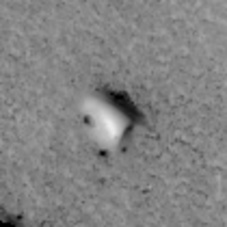

In [68]:
img = Image.open('images/train/bright dune/ESP_016631_2535_RED-0000.jpg', 'r')
img

In [93]:
transform_params = {'flip_vertical':True,
                  'flip_horizontal':True}
transform_params

{'flip_vertical': True, 'flip_horizontal': True}

In [78]:
np.array(img).shape

(227, 227)

In [54]:
len(train_generator)

383

In [110]:
train_generator.target_size

(227, 227)

In [109]:
val_generator.target_size

(227, 227)

# Model

In [141]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(227,227,1)))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))

In [142]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [143]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 225, 225, 16)      160       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 112, 112, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 55, 55, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 26, 26, 64)     

In [145]:
model.fit(train_generator, 
          steps_per_epoch=8,
          epochs=10, 
          validation_data = val_generator,
          validation_steps=8,
          verbose = 2
         )

Epoch 1/10
8/8 - 6s - loss: 0.8157 - accuracy: 0.8145 - val_loss: 0.9139 - val_accuracy: 0.8076 - 6s/epoch - 754ms/step
Epoch 2/10
8/8 - 6s - loss: 0.7633 - accuracy: 0.8281 - val_loss: 0.7934 - val_accuracy: 0.8086 - 6s/epoch - 710ms/step
Epoch 3/10
8/8 - 6s - loss: 0.7912 - accuracy: 0.8066 - val_loss: 0.8973 - val_accuracy: 0.7832 - 6s/epoch - 720ms/step
Epoch 4/10
8/8 - 5s - loss: 0.8200 - accuracy: 0.7998 - val_loss: 0.8496 - val_accuracy: 0.7959 - 5s/epoch - 664ms/step
Epoch 5/10
8/8 - 5s - loss: 0.7785 - accuracy: 0.8184 - val_loss: 0.8838 - val_accuracy: 0.7861 - 5s/epoch - 659ms/step
Epoch 6/10
8/8 - 5s - loss: 0.7552 - accuracy: 0.8125 - val_loss: 0.8272 - val_accuracy: 0.7910 - 5s/epoch - 605ms/step
Epoch 7/10
8/8 - 5s - loss: 0.7041 - accuracy: 0.8203 - val_loss: 0.8716 - val_accuracy: 0.7822 - 5s/epoch - 598ms/step
Epoch 8/10
8/8 - 4s - loss: 0.6941 - accuracy: 0.8281 - val_loss: 0.7972 - val_accuracy: 0.7979 - 4s/epoch - 555ms/step
Epoch 9/10
8/8 - 5s - loss: 0.6678 - acc